# Garbage Classification using PyTorch

Import the libraries

In [1]:
#1.8.1     0.9.1
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

드라이브 마운트 & class 확인:

In [2]:
data_dir  = 'dataset/'
classes = os.listdir(data_dir)

print(classes)
print(len(classes))

['cd', 'Disposable chopsticks', 'PET', '건전지', '계란판', '고무장갑', '드라이버', '마스크', '상자', '스파우트파우치', '스프링노트', '아이스팩', '알약', '영수증', '요구르트병', '유리', '은박보냉백', '종이', '종이팩', '칫솔', '캔', '플라스틱', '플라스틱통', '헤어드라이어']
24


## Transformations:

Dataset 불러오고 변환 후 저장


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


transformations = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = ImageFolder(data_dir, transform = transformations)

dataset이 잘 불러와졌는지 확인

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def imshow_denormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    imshow_denormalize(img)
    
    
def show_batch(dl):
    images, labels = dl[0]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))

Label: PET (Class No: 1)


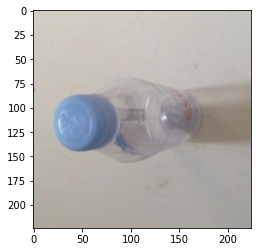

In [5]:
img, label = dataset[1000]
show_sample(img, label)

Batch가 잘 나눠졌는지 확인하기 위해 시각화


# Model Base:

In [6]:
def accuracy(outputs, labels):
    """출력과 정답을 비교해 top-1 정확도를 반환"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

##self.backbone = models.resnet50(pretrained=True) 수정



- resnet18 = models.resnet18(pretrained=True)
- alexnet = models.alexnet(pretrained=True)
- squeezenet = models.squeezenet1_0(pretrained=True)
- vgg16 = models.vgg16(pretrained=True)
- densenet = models.densenet161(pretrained=True)
- inception = models.inception_v3(pretrained=True)
- googlenet = models.googlenet(pretrained=True)
- shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
- mobilenet_v2 = models.mobilenet_v2(pretrained=True)
- mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
- mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
- resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
- wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
- mnasnet = models.mnasnet1_0(pretrained=True)

Reference : https://pytorch.org/vision/stable/models.html

In [7]:
class TrashNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, len(dataset.classes))
    
    def forward(self, xb):
        return torch.softmax(self.backbone(xb), dim=1)

    def get_loss(self, batch):
        """batch에 대해 cross entropy loss를 계산 후 반환"""
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def test(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'test_loss': loss.detach(), 'test_acc': acc}

## GPU 병렬 처리:

In [8]:
def list_to_device(batch, device):
    """list로 된 batch의 각 원소를 device에 올려줌"""
    converted_batch = []
    for data in batch:
        converted_batch.append(data.to(device, non_blocking=True))
    return converted_batch

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'current device = {device}')

current device = cuda


# Training the Model:

This is the function for fitting the model.

In [10]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.test(list_to_device(batch,device)) for batch in test_loader] # 각 batch별 loss, acc 저장
    
    batch_losses = [x['test_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['test_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}


def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.get_loss(list_to_device(batch, device))
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
     
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        history.append(result)
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, test_loss: {result['test_loss']:.4f}, test_acc: {result['test_acc']:.4f}")
    return history

모델 학습:

In [11]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

num_epochs = 8
opt_func = torch.optim.Adam
lr = 2.0e-5 # 3e-4
batch_size = 16

model = None
history = None
avg_acc = 0
kf = KFold(n_splits=8, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    cur_model = TrashNet().to(device)
    print(f'======== fold no.{fold+1} ============')
    
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)
    train_dl = DataLoader(dataset, batch_size, sampler=train_subsampler, num_workers = 2, pin_memory = True)
    test_dl = DataLoader(dataset, batch_size, sampler=test_subsampler, num_workers = 2, pin_memory = True)
    
    cur_history = fit(num_epochs, lr, cur_model, train_dl, test_dl, opt_func)
    avg_acc += cur_history[-1]['test_acc'] 
    if not history or cur_history[-1]['test_acc'] > history[-1]['test_acc']:
        model = cur_model
        history = cur_history

print(f'Average accuracy: {avg_acc / 8}, Maximum accuracy: {history[-1]["test_acc"]}')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Shim/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
28.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

74.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


======== fold no.1 ============
Epoch 1: train_loss: 2.6030, test_loss: 2.4624, test_acc: 0.7936
Epoch 2: train_loss: 2.4015, test_loss: 2.3391, test_acc: 0.9211
Epoch 3: train_loss: 2.3270, test_loss: 2.3176, test_acc: 0.9387
Epoch 4: train_loss: 2.3053, test_loss: 2.3264, test_acc: 0.9309
Epoch 5: train_loss: 2.2910, test_loss: 2.3136, test_acc: 0.9387
Epoch 6: train_loss: 2.2825, test_loss: 2.3236, test_acc: 0.9297
Epoch 7: train_loss: 2.2796, test_loss: 2.3190, test_acc: 0.9308
Epoch 8: train_loss: 2.2766, test_loss: 2.3153, test_acc: 0.9344
======== fold no.2 ============
Epoch 1: train_loss: 2.5769, test_loss: 2.4254, test_acc: 0.8335
Epoch 2: train_loss: 2.4010, test_loss: 2.3553, test_acc: 0.9039
Epoch 3: train_loss: 2.3404, test_loss: 2.3259, test_acc: 0.9301
Epoch 4: train_loss: 2.3065, test_loss: 2.3239, test_acc: 0.9346
Epoch 5: train_loss: 2.2954, test_loss: 2.3201, test_acc: 0.9357
Epoch 6: train_loss: 2.2883, test_loss: 2.3114, test_acc: 0.9401
Epoch 7: train_loss: 2.280

KeyboardInterrupt: 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['test_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    test_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Test'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

#Saving the model

In [ ]:
Path = '/savedModels/'
FileName = 'resnet18.pt'
torch.save(model, Path+FileName)

# Visualizing Predictions:
Test set에 있는 이미지들 예측 결과입니다.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[102]
#plt.imshow(img.permute(1, 2, 0))
imshow_denormalize(img)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# 직접 찍은 사진들로 테스트한 결과입니다.

savedModels 디렉토리에 저장된 모델을 가져옵니다.
- loaded_model = model : 위에서 학습한 모델 사용
- loaded_model = torch.load('~/modelname.pt') : 모델 불러오기 
- model.eval() : 모델의 모드를 evaluation 모드로 바꿉니다. (prediction을 위해)

Ref : https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [ ]:
loaded_model = model

'''
loaded_model = TrashNet()
Path = '/savedModels/'
FileName = 'resnext50_32x4d.pt'
loaded_model = torch.load(Path+FileName)
'''
model.eval()

This function takes the image's name and prints the predictions:

In [ ]:
from PIL import Image
from pathlib import Path

image_path = '/test/'
def predict_external_image(image_name):
    image = Image.open(Path(image_path + image_name))
    example_image = transformations(image)
    #plt.imshow(example_image.permute(1, 2, 0))
    imshow_denormalize(example_image)
    print("이 물건은 ", predict_image(example_image, loaded_model) + "입니다.")

In [ ]:
predict_external_image('test_cd2.jpg')

In [ ]:
predict_external_image('test_tooth brush.jpg')

In [ ]:
predict_external_image('test_rubber glove.jpg')

In [ ]:
predict_external_image('test_hairdryer.jpg')

In [ ]:
predict_external_image('test_egg1.jpg')

In [ ]:
predict_external_image('test_PET.jpg')

In [ ]:
predict_external_image('test_yogurt.jpg')

In [ ]:
predict_external_image('test_sd1.jpg')

In [ ]:
predict_external_image('test_sd2.jpg')

In [ ]:
predict_external_image('test_mask1.jpg')

In [ ]:
predict_external_image('test_mask2.jpg')

In [ ]:
predict_external_image('test_notebook1.jpg')

In [ ]:
predict_external_image('test_notebook3.jpg')

In [ ]:
predict_external_image('test_icepack2.jpg')

In [ ]:
predict_external_image('test_receipt1.jpg')

In [ ]:
predict_external_image('test_receipt2.jpg')

In [ ]:
predict_external_image('test_receipt3.jpg')

In [ ]:
predict_external_image('test_receipt4.jpg')

In [ ]:
predict_external_image('test_pill1.jpg')

In [ ]:
predict_external_image('test_pill2.jpg') # 2 class가 한 이미지에 있을 때.  0.6874

#Convert PyTorch models to Core ML

https://developer.apple.com/videos/play/tech-talks/10154/

In [ ]:
!pip install -U coremltools
import coremltools as ct

In [ ]:
sample_img = dataset[0][0]
sample_img = to_device(sample_img.unsqueeze(0), device)

In [ ]:
traced_model = torch.jit.trace(loaded_model, sample_img)
_input = ct.ImageType(
    name = "InputImg",
    shape = sample_img.shape,
    bias = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    scale = 1./(255*0.226)
)
#    
print(sample_img.shape)
print(dataset.classes)
classifier_config = ct.ClassifierConfig(dataset.classes)

In [ ]:
mlmodel = ct.convert(
    traced_model,
    inputs= [_input],
    classifier_config=classifier_config
)

mlmodel.short_description = "Trash Image Classifier"
mlmodel.save("/content/drive/MyDrive/캡디/TrashClassificationModel.mlmodel")

저장...